<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Creating a simple 2D scarp diffusion model with Landlab

<hr>
<small> For instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For the unexpanded version to download and run, click here: <a href="https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/fault_scarp/landlab-fault-scarp-unexpanded.ipynb">https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/fault_scarp/landlab-fault-scarp-unexpanded.ipynb</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>


This tutorial illustrates how you can use Landlab to construct a simple two-dimensional numerical model on a regular (raster) grid, using a simple forward-time, centered-space numerical scheme. The example is the erosional degradation of an earthquake fault scarp, and which evolves over time in response to the gradual downhill motion of soil. Here we use a simple "geomorphic diffusion" model for landform evolution, in which the downhill flow of soil is assumed to be proportional to the (downhill) gradient of the land surface multiplied by a transport coefficient.

We start by importing the *NumPy* library, which we'll use for some array calculations:

In [1]:
import numpy

We will create a grid for our model using Landlab's *RasterModelGrid* class, which we need to import.

In [2]:
from landlab import RasterModelGrid

The syntax in the next line says: create a new *RasterModelGrid* object called **mg**, with 25 rows, 40 columns, and a grid spacing of 10 m.

In [3]:
mg = RasterModelGrid((25, 40), 10.0)

Now we'll add a *data field* to the grid, to represent the elevation values at grid nodes. The "dot" syntax indicates that we are calling a function (or *method*) that belongs to the *RasterModelGrid* class, and will act on data contained in **mg**. The arguments indicate that we want the data elements attached to grid nodes (rather than links, for example), and that we want to name this data field `topographic__elevation`. The `add_zeros` method returns the newly created NumPy array.

In [4]:
z = mg.add_zeros('node', 'topographic__elevation')

Let's take a look at the grid we've created. To do so, we'll use the Matplotlib graphics library (imported under the name `plt`). We also have to tell the iPython Notebook to display plots right here on the page.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

Let's plot the positions of all the grid nodes. The nodes' *(x,y)* positions are stored in the arrays `mg.x_of_node` and `mg.y_of_node`, respectively.

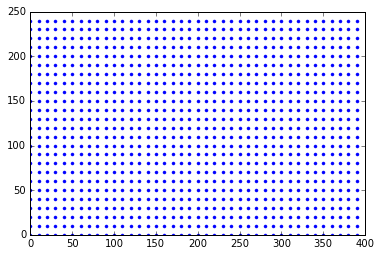

In [6]:
plt.plot(mg.x_of_node, mg.y_of_node, '.')

If we bothered to count, we'd see that there are 1000 grid nodes (25 x 40). The `z` array also has 1000 entries: one per grid cell.

In [7]:
len(z)

1000

Now for some tectonics. Let's say there's a fault trace that angles roughly east-northeast. We can describe the trace with the equation for a line. One trick here: by using `mg.node_x`, we are calculating a *y* (i.e., north-south) position of the fault trace for each grid node---meaning that this is the *y* coordinate of the trace at the *x* coordinate of a given node.

In [8]:
fault_trace_y = 50.0 + 0.25*mg.x_of_node

We find the ID numbers of the nodes north of the fault trace with help from Numpy's `where()` function.

In [9]:
upthrown_nodes = numpy.where(mg.y_of_node > fault_trace_y)

Here comes the earthquake. For all the nodes that we identified as being north of the fault, we'll add elevation equal to 10 meters plus a centimeter for every meter east along the grid (just to make it interesting).

In [10]:
z[upthrown_nodes] += 10.0 + 0.01*mg.x_of_node[upthrown_nodes]

Let's look at our newly created initial topography using Landlab's *imshow_node_grid* plotting function (which we first need to import).

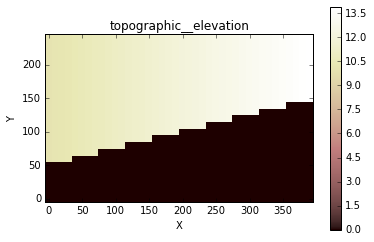

In [11]:
from landlab.plot.imshow import imshow_grid_at_node
imshow_grid_at_node(mg, 'topographic__elevation')

To finish getting set up, we will define two parameters: the transport ("diffusivity") coefficient, `D`, and the time-step size, `dt`. (The latter is set using the Courant condition for a forward-time, centered-space finite-difference solution.)

In [12]:
D = 0.01  # m2/yr transport coefficient
dt = 0.2 * mg.dx * mg.dx / D
dt

2000.0

Boundary conditions: for this example, we'll assume that the east and west sides are closed to flow of sediment, but that the north and south sides are open. (The order of the function arguments is east, north, west, south)

In [13]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

*A note on boundaries:* with a Landlab raster grid, all the perimeter nodes are boundary nodes. In this example, there are 24 + 24 + 39 + 39 = 126 boundary nodes. The previous line of code set those on the east and west edges to be **closed boundaries**, while those on the north and south are **open boundaries** (the default). All the remaining nodes are known as **core** nodes. In this example, there are 1000 - 126 = 874 core nodes:

In [14]:
len(mg.core_nodes)

874

One more thing before we run the time loop: we'll create an array to contain soil flux. In the function call below, the first argument tells Landlab that we want one value for each grid link, while the second argument provides a name for this data *field*:

In [15]:
qs = mg.add_zeros('link', 'sediment_flux')

And now for some landform evolution. We will loop through 25 iterations, representing 50,000 years. On each pass through the loop, we do the following:

1. Calculate, and store in the array `g`, the gradient between each neighboring pair of nodes. These calculations are done on **links**. The gradient value is a positive number when the gradient is "uphill" in the direction of the link, and negative when the gradient is "downhill" in the direction of the link. On a raster grid, link directions are always in the direction of increasing $x$ ("horizontal" links) or increasing $y$ ("vertical" links).

2. Calculate, and store in the array `qs`, the sediment flux between each adjacent pair of nodes by multiplying their gradient by the transport coefficient. We will only do this for the **active links** (those not connected to a closed boundary, and not connecting two boundary nodes of any type); others will remain as zero.

3. Calculate, and store in `dqsdx`, the resulting net flux at each node (positive=net outflux, negative=net influx).

4. The rate of change of node elevation, `dzdt`, is simply `-dqsdx`.

5. Update the elevations for the new time step.

In [16]:
for i in range(25):
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dqsdx = mg.calc_flux_div_at_node(qs)
    dzdt = -dqsdx
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt

Let's look at how our fault scarp has evolved.

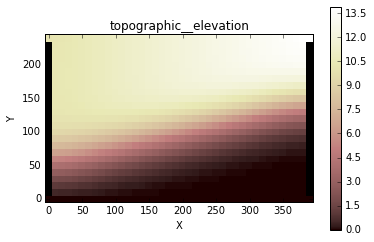

In [17]:
imshow_grid_at_node(mg, 'topographic__elevation')

Notice that we have just created and run a 2D model of fault-scarp creation and diffusion with fewer than two dozen lines of code. How long would this have taken to write in C or Fortran?

Complete code can be found here: https://github.com/landlab/tutorials/blob/master/fault_scarp/landlab-fault-scarp.py

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>